In [1]:
import sys
sys.path.insert(0, '..')
import cv2
from openpose.hand import Hand
from openpose.body import Body
import matplotlib.pyplot as plt
import copy
import numpy as np
import math

body_estimation = Body('../model/body_pose_model.pth')

test_image = '../images/demo.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset = body_estimation(oriImg)

In [2]:
limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
               [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
               [1, 16], [16, 18], [3, 17], [6, 18]]
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
canvas = copy.deepcopy(oriImg)

In [3]:
# right hand: wrist 4, elbow 3, shoulder 2
# left hand: wrist 7, elbow 6, shoulder 5
ratioWristElbow = 0.33
detect_result = []
image_height = oriImg.shape[0]
image_width = oriImg.shape[1]
for person in subset.astype(int):
    has_left = np.sum(person[[5, 6, 7]] == -1) == 0
    has_right = np.sum(person[[2, 3, 4]] == -1) == 0
    if not (has_left or has_right):
        continue
    # if any of three not detected
    if has_left:
        left_shoulder_index, left_elbow_index, left_wrist_index = person[[5, 6, 7]]
        # pos_hand = pos_wrist + ratio * (pos_wrist - pos_elbox) = (1 + ratio) * pos_wrist - ratio * pos_elbox
        # handRectangle.x = posePtr[wrist*3] + ratioWristElbow * (posePtr[wrist*3] - posePtr[elbow*3]);
        # handRectangle.y = posePtr[wrist*3+1] + ratioWristElbow * (posePtr[wrist*3+1] - posePtr[elbow*3+1]);
        # const auto distanceWristElbow = getDistance(poseKeypoints, person, wrist, elbow);
        # const auto distanceElbowShoulder = getDistance(poseKeypoints, person, elbow, shoulder);
        # handRectangle.width = 1.5f * fastMax(distanceWristElbow, 0.9f * distanceElbowShoulder);
        x1, y1 = candidate[left_shoulder_index][:2]
        x2, y2 = candidate[left_elbow_index][:2]
        x3, y3 = candidate[left_wrist_index][:2]
        
        cv2.line(canvas, (int(x2), int(y2)), (int(x3), int(y3)), colors[0], thickness=4)
        cv2.line(canvas, (int(x2), int(y2)), (int(x1), int(y1)), colors[1], thickness=4)
        
        cv2.circle(canvas, (int(x1), int(y1)), 4, colors[2], thickness=-1)
        cv2.circle(canvas, (int(x2), int(y2)), 4, colors[3], thickness=-1)
        cv2.circle(canvas, (int(x3), int(y3)), 4, colors[4], thickness=-1)
        
        x = x3 + ratioWristElbow*(x3-x2)
        y = y3 + ratioWristElbow*(y3-y2)
        distanceWristElbow = math.sqrt((x3-x2)**2+(y3-y2)**2)
        distanceElbowShoulder = math.sqrt((x2-x1)**2+(y2-y1)**2)
        width = 1.5*max(distanceWristElbow, 0.9*distanceElbowShoulder)
        # x-y refers to the center --> offset to topLeft point
        # handRectangle.x -= handRectangle.width / 2.f;
        # handRectangle.y -= handRectangle.height / 2.f;
        x -= width/2
        y -= width/2 # width = height
        is_left = True
        if x<0: x=0
        if y<0: y=0
        width1 = width
        width2 = width
        if x+width>image_width: width1=image_width-x
        if y+width>image_height: width2=image_height-y
        width = min(width1, width2)
        detect_result.append([int(x), int(y), int(width), is_left])

    # right hand
    if has_right:
        right_shoulder_index, right_elbow_index, right_wrist_index = person[[2, 3, 4]]
        x1, y1 = candidate[right_shoulder_index][:2]
        x2, y2 = candidate[right_elbow_index][:2]
        x3, y3 = candidate[right_wrist_index][:2]
        
        cv2.line(canvas, (int(x2), int(y2)), (int(x3), int(y3)), colors[2], thickness=4)
        cv2.line(canvas, (int(x2), int(y2)), (int(x1), int(y1)), colors[3], thickness=4)
        
        cv2.circle(canvas, (int(x1), int(y1)), 4, colors[2], thickness=-1)
        cv2.circle(canvas, (int(x2), int(y2)), 4, colors[3], thickness=-1)
        cv2.circle(canvas, (int(x3), int(y3)), 4, colors[4], thickness=-1)
        
        x = x3 + ratioWristElbow*(x3-x2)
        y = y3 + ratioWristElbow*(y3-y2)
        distanceWristElbow = math.sqrt((x3-x2)**2+(y3-y2)**2)
        distanceElbowShoulder = math.sqrt((x2-x1)**2+(y2-y1)**2)
        width = 1.5*max(distanceWristElbow, 0.9*distanceElbowShoulder)
        x -= width/2
        y -= width/2 # width = height
        is_left = False
        if x<0: x=0
        if y<0: y=0
        width1 = width
        width2 = width
        if x+width>image_width: width1=image_width-x
        if y+width>image_height: width2=image_height-y
        width = min(width1, width2)
        detect_result.append([int(x), int(y), int(width), is_left])

In [4]:
detect_result

[[0, 0, 167, False], [0, 426, 31, True]]

In [5]:
for x, y, w, is_left in detect_result:
    cv2.rectangle(canvas, (x, y), (x+w, y+w), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    cv2.putText(canvas, 'left' if is_left else 'right', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), lineType=cv2.LINE_AA)

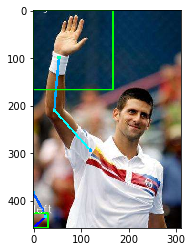

In [6]:
plt.imshow(canvas[:, :, [2, 1, 0]])